# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
!pip install httpagentparser


  Running setup.py bdist_wheel for httpagentparser ... done
  Stored in directory: /root/.cache/pip/wheels/28/30/df/38acb521e72600043491ceadd08d98f383b5bf819cebd2fb03
Successfully built httpagentparser


In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType,TimestampType,IntegerType
from pyspark.sql.functions import sum as Fsum
import pyspark.sql.functions as F 
#from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql import Window
import datetime
from pyspark.ml.feature import StringIndexer
import httpagentparser
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
path = "./mini_sparkify_event_data.json"
data_log = spark.read.json(path)

In [5]:
data_log = data_log.dropDuplicates()

In [6]:
data_log.take(1)

[Row(artist='The Futureheads', auth='Logged In', firstName='Ainsley', gender='F', itemInSession=80, lastName='Farley', length=120.81587, level='free', location='McAllen-Edinburg-Mission, TX', method='PUT', page='NextSong', registration=1538304455000, sessionId=187, song='Robot', status=200, ts=1538373133000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', userId='78')]

In [7]:
# print the schema
data_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# filter for users with blank user id
blank_pages = data_log.filter(data_log.userId == '') \
    .select(F.col('page') \
    .alias('blank_pages')) \
    .dropDuplicates()

# get a list of possible pages that could be visited
all_pages = data_log.select('page').dropDuplicates()

In [9]:
# values in all_pages that are not in blank_pages
# these are the pages that the blank user did not go to
for row in set(all_pages.collect()) - set(blank_pages.collect()):
    print(row.page)

Add to Playlist
Submit Upgrade
Cancel
Upgrade
Logout
Cancellation Confirmation
Submit Downgrade
Add Friend
Save Settings
Roll Advert
Settings
Thumbs Down
Thumbs Up
NextSong
Downgrade


In [10]:
# count most played song
data_log.filter(data_log.page == 'NextSong') \
    .select('song','Artist') \
    .groupBy('song','Artist') \
    .agg({'song':'count'}) \
    .withColumnRenamed('count(song)', 'Songcount') \
    .sort(F.desc('Songcount')) \
    .show(5)

+--------------------+--------------------+---------+
|                song|              Artist|Songcount|
+--------------------+--------------------+---------+
|      You're The One|       Dwight Yoakam|     1122|
|                Undo|            BjÃÂ¶rk|     1026|
|             Revelry|       Kings Of Leon|      854|
|       Sehr kosmisch|            Harmonia|      728|
|Horn Concerto No....|Barry Tuckwell/Ac...|      641|
+--------------------+--------------------+---------+
only showing top 5 rows



In [11]:
# count most played artists
data_log.filter(data_log.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(F.desc('Artistcount')) \
    .show(5)

+--------------------+-----------+
|              Artist|Artistcount|
+--------------------+-----------+
|       Kings Of Leon|       1841|
|            Coldplay|       1813|
|Florence + The Ma...|       1236|
|       Dwight Yoakam|       1135|
|            BjÃÂ¶rk|       1133|
+--------------------+-----------+
only showing top 5 rows



In [12]:
# top location
data_log.select('location') \
    .groupBy('location') \
    .agg({'location':'count'}) \
    .withColumnRenamed('count(location)', 'locationcount') \
    .sort(F.desc('locationcount')) \
    .show(5)

+--------------------+-------------+
|            location|locationcount|
+--------------------+-------------+
|Los Angeles-Long ...|        30131|
|New York-Newark-J...|        23684|
|Boston-Cambridge-...|        13873|
|Houston-The Woodl...|         9499|
|Charlotte-Concord...|         7780|
+--------------------+-------------+
only showing top 5 rows



This could be attributed to users that not signed up yet

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
# get timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [15]:
data_log = data_log.withColumn("hour", get_hour(data_log.ts))

In [16]:
data_log.head()

Row(artist='The Futureheads', auth='Logged In', firstName='Ainsley', gender='F', itemInSession=80, lastName='Farley', length=120.81587, level='free', location='McAllen-Edinburg-Mission, TX', method='PUT', page='NextSong', registration=1538304455000, sessionId=187, song='Robot', status=200, ts=1538373133000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', userId='78', hour='5')

In [17]:
songs_in_hour = data_log.filter(data_log.page == "NextSong").groupby(data_log.hour).count().orderBy(data_log.hour.cast("float"))

In [18]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

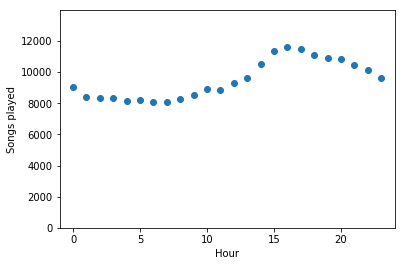

In [19]:
# what are the time that songs are played
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [20]:
# what time people listened more the top 1 artist?
data_log.filter(data_log.page == 'NextSong') \
    .select('Artist','hour') \
    .groupBy('Artist','hour') \
    .agg({'Hour':'count'}) \
    .withColumnRenamed('count(Hour)', 'Hourcount') \
    .sort(F.desc('Hourcount')) \
    .show(1)

+-------------+----+---------+
|       Artist|hour|Hourcount|
+-------------+----+---------+
|Kings Of Leon|  15|      109|
+-------------+----+---------+
only showing top 1 row



In [21]:
# remove null values
data_log_valid = data_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [22]:
data_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [23]:
# remove empty string for userid
data_log_valid = data_log_valid.filter(data_log_valid["userId"] != "")

In [24]:
# count gender
data_log_valid.select('gender','userId') \
    .groupBy('gender') \
    .agg(F.countDistinct("userId")) \
    .withColumnRenamed('count(userId)', 'userIdcount')\
    .show() 

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|     F|                   104|
|     M|                   121|
+------+----------------------+



In [25]:
# count paid and free user
data_log_valid.select('level','userId') \
    .groupBy('level') \
    .agg(F.countDistinct("userId")) \
    .withColumnRenamed('count(userId)', 'userIdcount')\
    .show() 

+-----+----------------------+
|level|count(DISTINCT userId)|
+-----+----------------------+
| free|                   195|
| paid|                   165|
+-----+----------------------+



In [26]:
# how many users?
data_log_valid.select('userId').distinct().count()

225

In [27]:
data_log_valid.select('location').distinct().count()

114

In [28]:
# define churn by cancellation confirmation

In [29]:
data_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|   Parker|     M|          636|Williams|  null| paid|San Francisco-Oak...|   PUT|Submit Downgrade|1537188538000|      529|null|   307|1539244188000|"Mozilla/5.0 (iPh...|    61|   7|
|  null|Logged In| Benjamin|     M|           89|    Mata|  null| paid|        Sterling, IL|   PUT|Submit Downgrade|1538313468000|      251|null|   307|1540873341000|"Mozilla/5.0 (Win...|200009|   4|


In [30]:
# downgraded event
downgraded_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())

In [31]:
data_log_valid = data_log_valid.withColumn("downgraded", downgraded_event("page"))

In [32]:
# using unboundedPreceding to identify the movement from non paid user to paid user
windowval = Window.partitionBy("userId").orderBy(F.desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [33]:
data_log_valid = data_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [34]:
data_log_valid.select(["userId", "firstname", "ts", "page", "level","phase"]).where(data_log_valid.userId == "30").sort("ts").collect()

[Row(userId='30', firstname='Colin', ts=1538352117000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538352394000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538352676000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538352899000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538352905000, page='Add to Playlist', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538353084000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538353218000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538353441000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538353687000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538353909000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Coli

In [35]:
# session duration in minutes
session_duration = data_log_valid.withColumn('session_length', F.sum('length')\
                                             .over(Window.partitionBy('SessionId'))/60)\
                                            .select('sessionId','session_length')\
                                            .dropDuplicates()
session_duration.select('session_length').describe().show()

+-------+------------------+
|summary|    session_length|
+-------+------------------+
|  count|              2253|
|   mean|420.37004103121774|
| stddev| 468.6194947226623|
|    min|         2.5578155|
|    max|4462.6355484999995|
+-------+------------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [36]:
# transform gender to numeric
gender = data_log_valid.select('userId','gender')\
            .dropDuplicates()\
            .withColumn('gender_flag', F.when(F.col('gender')=='F',1).otherwise(0))\
            .drop('gender')
data_log_valid = data_log_valid.join(gender,on=['userId'], how='left')

In [37]:
# defining churn
data_log_valid = data_log_valid.withColumn('churn', F.when(data_log_valid.page == 'Cancellation Confirmation', 1)\
                       .otherwise(0))
data_log_valid = data_log_valid.withColumn('user_churn_flag', F.max('churn').over(Window.partitionBy('UserId')))


In [38]:
# paid sessions by user
paid_sessions = data_log_valid.select('userId', 'sessionId')\
                        .where(data_log_valid.level == 'paid')\
                        .groupBy('userId')\
                        .count() \
                        .withColumnRenamed('count', 'paid_sessions')
data_log_valid = data_log_valid.join(paid_sessions,on=['userId'], how='left')


In [39]:
# transform timestamp
ts_to_dt = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0), TimestampType())
df = data_log_valid.withColumn('registration_dt', ts_to_dt(F.col('registration')))
df = df.withColumn('ts', ts_to_dt(F.col('ts')))

In [40]:

# count active days by user
active_days = df.select('userId','ts')\
                    .dropDuplicates()\
                    .groupby('userId')\
                    .count()\
                    .withColumnRenamed("count", "active_days_count")
df = df.join(active_days,on=['userId'], how='left')

In [41]:
# calculate the tenure days (the days that we have user in the platform)
max_date = df.select('ts').agg(F.max('ts')).collect()[0][0]
df = df.withColumn('tenure',F.datediff(F.lit(max_date), F.col('registration_dt')))


In [42]:
free = df.select('userId', 'sessionId')\
                        .where(df.level == 'free')\
                        .groupBy('userId')\
                        .count() \
                        .withColumnRenamed('count', 'free_sessions')
df = df.join(free,on=['userId'], how='left')

In [43]:
# songs per user
songs_per_user = df.select('userId','ts','song')\
                                .dropDuplicates()\
                                .groupby('userId')\
                                .count()\
                                .withColumnRenamed("count", "song_count")
df = df.join(songs_per_user,on=['userId'], how='left')

In [44]:
# identify user os,location and browser
udf_os = udf(lambda x: httpagentparser.simple_detect(x)[0].split(' ')[0], StringType())
udf_browser =  udf(lambda x: httpagentparser.simple_detect(x)[1].split(' ')[0], StringType())
udf_location = udf(lambda x: x.split(',')[1], StringType())

In [45]:
df = df.withColumn('location_state', udf_location('location'))


In [46]:
df = df.withColumn('browser', udf_browser('userAgent'))
df = df.withColumn('os', udf_os('userAgent'))


In [47]:
# count pages that users get access besid cancel and cancellation confirmatio
page_counts = df.select("userId", "page").groupBy("userId").pivot("page") \
    .count().drop("Cancel", "Cancellation Confirmation").fillna(0)


In [48]:
df = df.join(page_counts, on=['userId'], how='left')

In [142]:
df.take(1)

[Row(userId='100010', artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=datetime.datetime(2018, 11, 21, 18, 12, 32), userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', hour='18', downgraded=0, phase=0, gender_flag=1, churn=0, user_churn_flag=0, paid_sessions=None, registration_dt=datetime.datetime(2018, 9, 27, 2, 45, 40), active_days_count=377, tenure=67, free_sessions=381, song_count=381, location_state=' CT', browser='Safari', os='iPhone', About=1, Add Friend=4, Add to Playlist=7, Downgrade=0, Error=0, Help=2, Home=11, Logout=5, NextSong=275, Roll Advert=52, Save Settings=0, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2)]

In [49]:
current_condition = df.orderBy('ts', ascending=False).groupBy('userId') \
    .agg(F.first('level') \
    .alias('current_condition'))

In [50]:
df = df.join(current_condition, on=['userId'], how='left')

# get graphs using pandas


In [101]:

df_pandas = df.toPandas()

In [102]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 33 columns):
userId               278154 non-null object
artist               228108 non-null object
auth                 278154 non-null object
firstName            278154 non-null object
gender               278154 non-null object
itemInSession        278154 non-null int64
lastName             278154 non-null object
length               228108 non-null float64
level                278154 non-null object
location             278154 non-null object
method               278154 non-null object
page                 278154 non-null object
registration         278154 non-null int64
sessionId            278154 non-null int64
song                 228108 non-null object
status               278154 non-null int64
ts                   278154 non-null datetime64[ns]
userAgent            278154 non-null object
hour                 278154 non-null object
downgraded           278154 non-null int32
phase

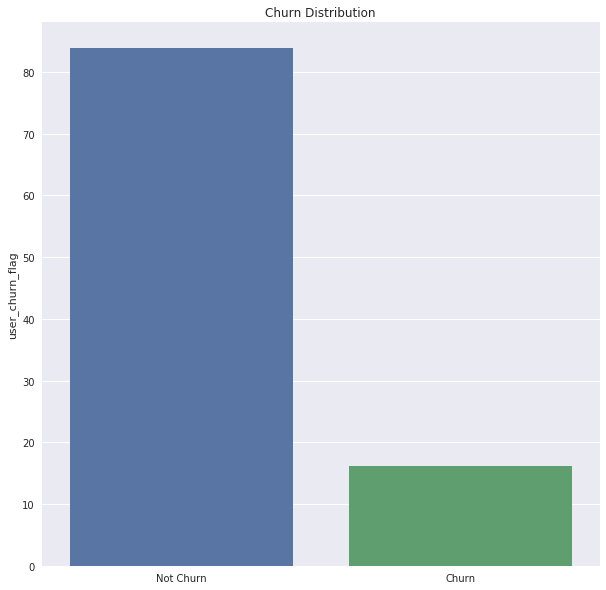

In [103]:
plt.figure(figsize=(10,10))
plt.title("Churn Distribution")
sns.barplot(x=['Not Churn','Churn'], y=df_pandas['user_churn_flag'].value_counts(normalize=True)*100);

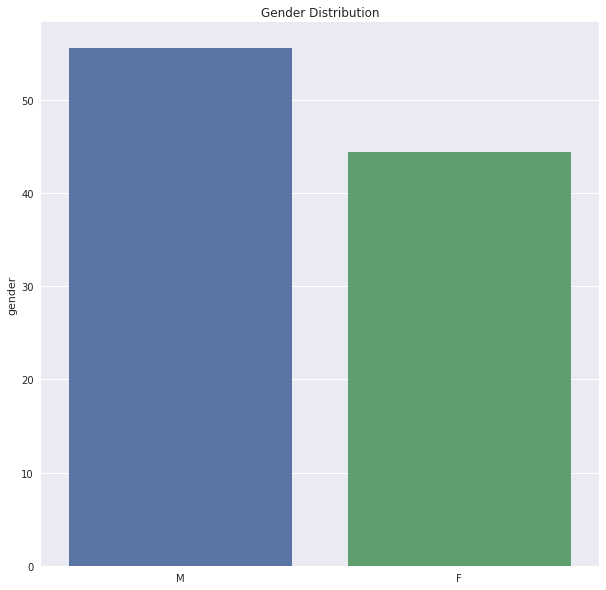

In [104]:
plt.figure(figsize=(10,10))
plt.title("Gender Distribution")
sns.barplot(x=['M','F'], y=df_pandas['gender'].value_counts(normalize=True)*100);

In [105]:
df.select('userId').dropDuplicates().count()

225

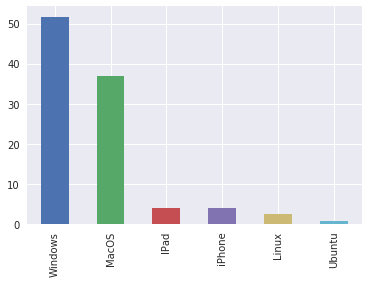

In [106]:
tmp = df_pandas['os'].value_counts(normalize=True)*100
tmp.plot(kind='bar')

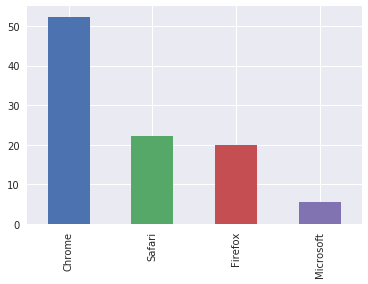

In [107]:
tmp_2 = df_pandas['browser'].value_counts(normalize=True)*100
tmp_2.plot(kind='bar')

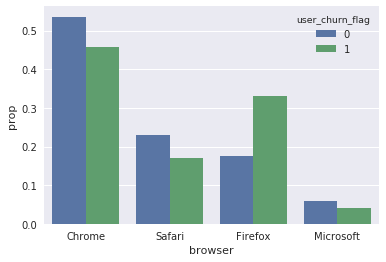

In [108]:

prop_df = (df_pandas['browser']
           .groupby(df_pandas['user_churn_flag'])
           .value_counts(normalize=True)
           .rename('prop')
           .reset_index())

sns.barplot(x='browser', y='prop', hue='user_churn_flag', data=prop_df,order=df_pandas['browser'].value_counts().index)

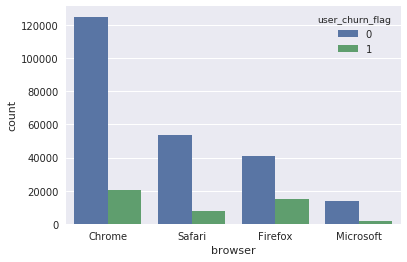

In [109]:
sns.set(style="darkgrid")
ax = sns.countplot(x='browser', hue="user_churn_flag", data=df_pandas,order=df_pandas['browser'].value_counts().index)
plt.show()

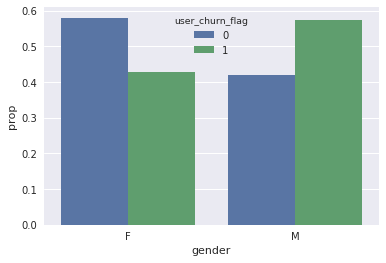

In [110]:

prop_df = (df_pandas['gender']
           .groupby(df_pandas['user_churn_flag'])
           .value_counts(normalize=True)
           .rename('prop')
           .reset_index())

sns.barplot(x='gender', y='prop', hue='user_churn_flag', data=prop_df,order=df_pandas['gender'].value_counts().index)

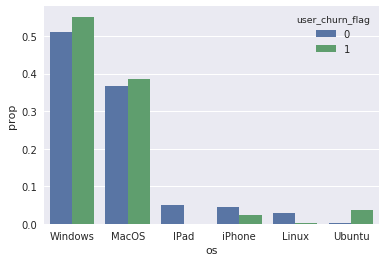

In [111]:

prop_df = (df_pandas['os']
           .groupby(df_pandas['user_churn_flag'])
           .value_counts(normalize=True)
           .rename('prop')
           .reset_index())

sns.barplot(x='os', y='prop', hue='user_churn_flag', data=prop_df,order=df_pandas['os'].value_counts().index)

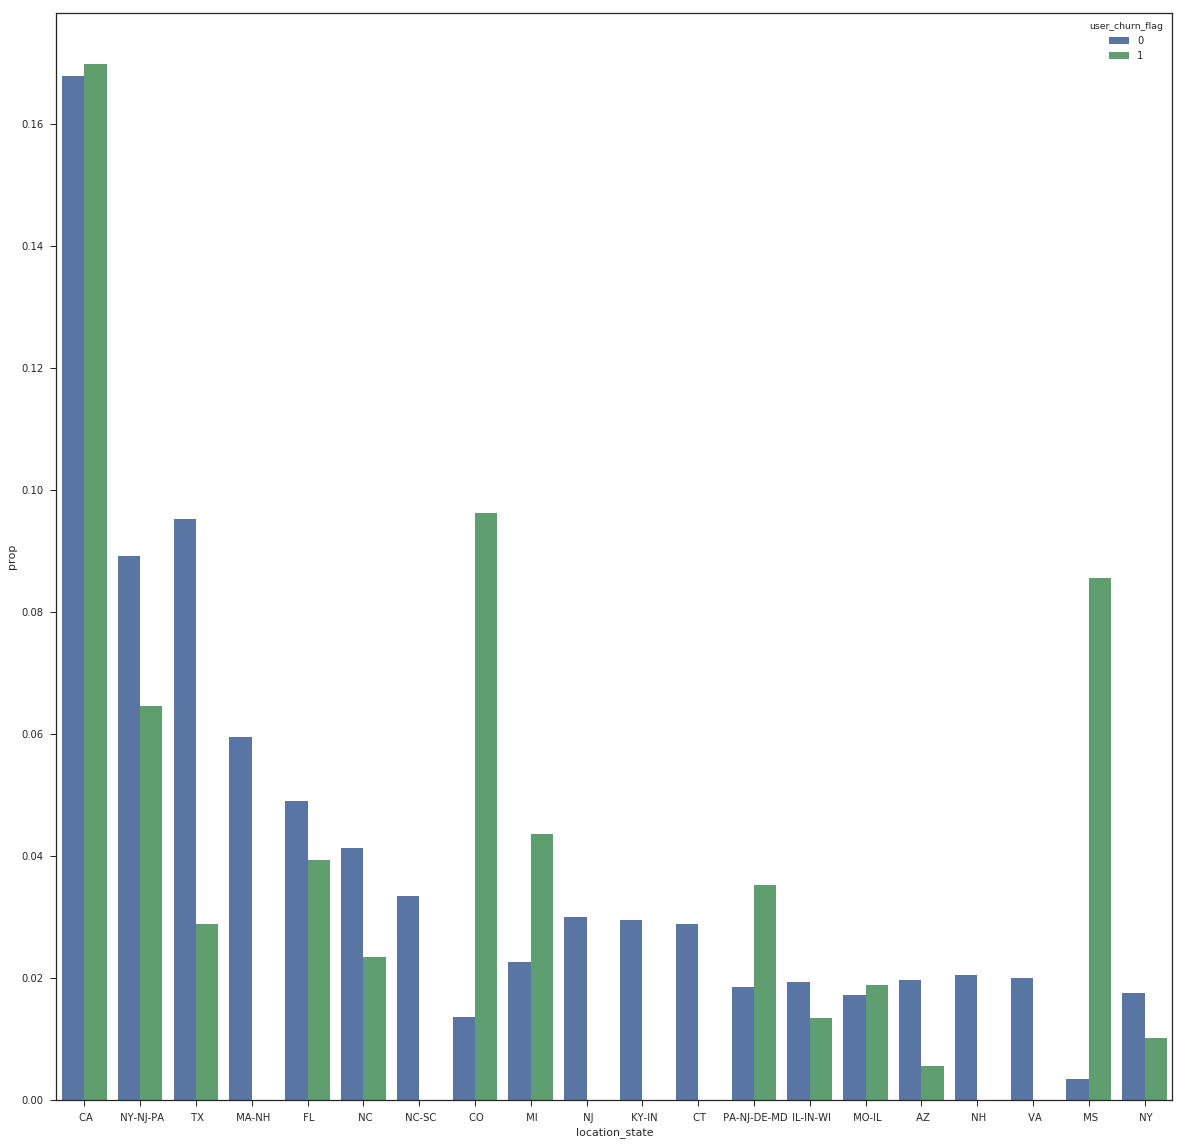

In [135]:
plt.figure(figsize=(20,20))
prop_df = (df_pandas['location_state']
           .groupby(df_pandas['user_churn_flag'])
           .value_counts(normalize=True)
           .rename('prop')
           .reset_index())

sns.barplot(x='location_state', y='prop', hue='user_churn_flag', data=prop_df,order=df_pandas['location_state'].value_counts()[:20].index)


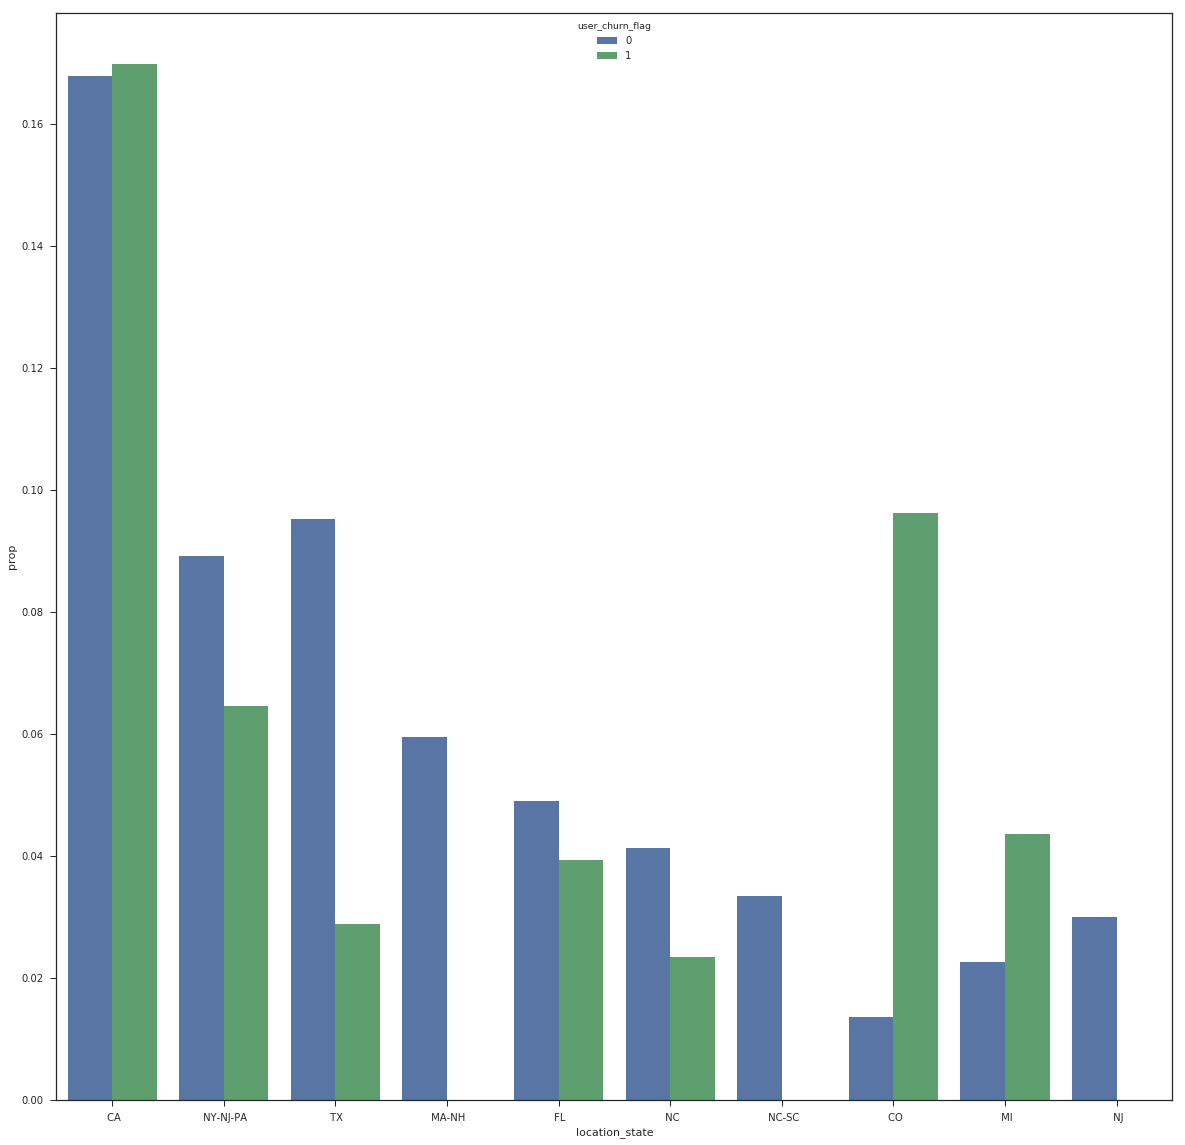

In [136]:
plt.figure(figsize=(20,20))
prop_df = (df_pandas['location_state']
           .groupby(df_pandas['user_churn_flag'])
           .value_counts(normalize=True)
           .rename('prop')
           .reset_index())

sns.barplot(x='location_state', y='prop', hue='user_churn_flag', data=prop_df,order=df_pandas['location_state'].value_counts()[:10].index)


# Modeling
Save data to json

In [52]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- phase: long (nullable = true)
 |-- gender_flag: integer (nullable = true)
 |-- churn: integer (nullable = false)
 |-- user_churn_flag: integer (nullable = true)
 |-- paid_sessions: long (nullable = true)
 |-- registra

In [51]:
# save the datframe for modeling 
df.write.json('final_df.json',mode='overwrite')